In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_feather('/content/drive/MyDrive/aitomatic/iot_pmfp_data.feather')
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")
df['anomaly'] = df['anomaly'].astype(int)
milestone = '2015-11-15 01:00:00'
train = df[df["datetime"] < pd.to_datetime(milestone)]
test = df[df["datetime"] >= pd.to_datetime(milestone)]
train.describe()

,machineID,volt,rotate,pressure,vibration,age,anomaly
count,762700.000000,762700.000000,762700.000000,762700.000000,762700.000000,762700.000000,762700.000000
mean,50.500000,170.785678,446.668016,100.835815,40.387361,11.330000,0.004984
std,28.866089,15.504525,52.622478,11.025737,5.371377,5.827619,0.070419
min,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000,0.000000
25%,25.750000,160.320389,412.370249,93.489397,36.779099,6.750000,0.000000
50%,50.500000,170.609742,447.649627,100.409111,40.238776,12.000000,0.000000
75%,75.250000,181.018743,482.201886,107.532548,43.792102,16.000000,0.000000
max,100.000000,250.870453,695.020984,185.951998,76.791072,20.000000,1.000000


In [ ]:
df['anomaly'].value_counts()

0    871768
1      4332
Name: anomaly, dtype: int64

<Axes: ylabel='Frequency'>

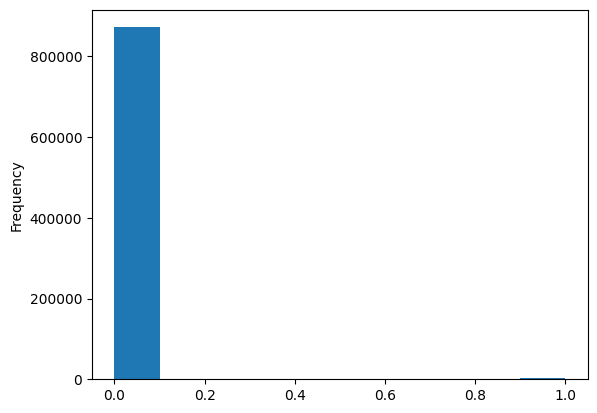

In [ ]:
# label distribution
df['anomaly'].plot(kind="hist")

In [ ]:
df['anomaly'].value_counts(),train['anomaly'].value_counts(),test['anomaly'].value_counts()

(0    871768
 1      4332
 Name: anomaly, dtype: int64,
 0    758899
 1      3801
 Name: anomaly, dtype: int64,
 0    112869
 1       531
 Name: anomaly, dtype: int64)

In [ ]:
#visualize categorical feature
train.groupby(['machineID','anomaly']).model.count()

machineID  anomaly
1          0          7589
           1            38
2          0          7602
           1            25
3          0          7592
                      ... 
98         1            49
99         0          7566
           1            61
100        0          7599
           1            28
Name: model, Length: 200, dtype: int64

In [ ]:
# fail rate for each machine
machine_r = train.groupby('machineID').anomaly.agg([sum,len])
machine_r['sum']/ machine_r['len']

machineID
1      0.004982
2      0.003278
3      0.004589
4      0.004196
5      0.004327
         ...   
96     0.005376
97     0.006031
98     0.006425
99     0.007998
100    0.003671
Length: 100, dtype: float64

In [ ]:
# fail rate for each model
model_r = train.groupby('model').anomaly.agg([sum,len])
(model_r['sum']/ model_r['len']).to_dict()

{'model1': 0.005588698046414055,
 'model2': 0.0055144648655318955,
 'model3': 0.0047687725936054245,
 'model4': 0.00463403041825095}

In [ ]:
# fail rate for each age
age_r = train.groupby('age').anomaly.agg([sum,len])
(age_r['sum']/ age_r['len']).to_dict()

{0: 0.004457847122066343,
 1: 0.005113412875311394,
 2: 0.004479699313841178,
 3: 0.005244526025960404,
 4: 0.005026004108212054,
 5: 0.004457847122066343,
 6: 0.004883964861675626,
 7: 0.004020803286569643,
 8: 0.004588960272715353,
 9: 0.004693850793234562,
 10: 0.004510292382325947,
 11: 0.0035400550675232724,
 12: 0.003998951094794808,
 14: 0.005900091779205454,
 15: 0.005506752327258424,
 16: 0.00532319391634981,
 17: 0.004776264773642511,
 18: 0.0052008216424107336,
 19: 0.005998426642192212,
 20: 0.005001030174755099}

In [ ]:
len(train['age'].unique())

20

In [ ]:
# check if features can seperate label
train[['volt', 'rotate', 'pressure', 'vibration','anomaly']].groupby('anomaly').agg([np.mean,np.std,min,max])

volt                                         rotate             \
               mean        std         min         max        mean        std   
anomaly                                                                         
0        170.775712  15.498560   97.333604  250.870453  446.714034  52.590177   
1        172.775498  16.535065  115.638391  235.493717  437.480099  57.997455   

                                   pressure                                    \
                min         max        mean        std        min         max   
anomaly                                                                         
0        138.432075  695.020984  100.828475  11.017544  51.237106  185.951998   
1        215.132706  646.235522  102.301394  12.470252  59.331808  168.992513   

         vibration                                  
              mean       std        min        max  
anomaly                                             
0        40.383509  5.367626  14.877054  76.791072  
1        41.156309  6.025603  24.148212  70.296929

In [ ]:
for field in ['machineID','age','model']:
  df_mean = train[['volt', 'rotate', 'pressure', 'vibration',field]].groupby(field).mean()
  df_mean = df_mean.add_prefix('mean_')
  df_std = train[['volt', 'rotate', 'pressure', 'vibration',field]].groupby(field).mean()
  df_std = df_std.add_prefix('std_')
  df = df_mean.join(df_std)
  rate = train.groupby(field).anomaly.agg([sum,len])
  df[f"{field}_rate"] = rate['sum']/ rate['len']
  df.to_csv(f"/content/drive/MyDrive/aitomatic/{field}.csv")

In [ ]:
train.to_csv("/content/drive/MyDrive/aitomatic/train.csv",index=False)
test.to_csv("/content/drive/MyDrive/aitomatic/test.csv",index=False)

In [ ]:
train.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'model', 'age', 'anomaly'],
      dtype='object')

In [ ]:
import librosa # try to use speech processing

In [ ]:
train['volt'].shape

(762700,)

In [ ]:

for field in ['volt', 'rotate', 'pressure', 'vibration']:
  S = librosa.core.stft(y=train[field].values, n_fft=24, win_length=12, hop_length=4)
  S = np.abs(S) ** 2
  mel_basis = librosa.filters.mel(sr=24, n_fft=24, n_mels=4)
  S = np.log10(np.dot(mel_basis, S) + 1e-6)  # log mel spectrogram of utterances
  S -= np.mean(S, axis=0)

In [ ]:
S.shape

(4, 190676)

In [ ]:
190676/6

31779.333333333332

In [ ]:
762700 / 24

31779.166666666668